In [8]:
from langchain.document_loaders import DirectoryLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain import HuggingFacePipeline
from langchain.chains import RetrievalQA
from transformers import AutoTokenizer, pipeline
from langchain.docstore.document import Document as LangchainDocument
from langchain.vectorstores.utils import DistanceStrategy

from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
import matplotlib.pyplot as plt

import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig
from transformers import AutoModel

#### Load Docs (pdf)

In [3]:
doc_loader = DirectoryLoader('./FOMC_docs_2023_2020', glob='**/*.pdf',     # load pdf files
    show_progress=True
)
docs = doc_loader.load()

  0%|                                                    | 0/64 [00:00<?, ?it/s]This function will be deprecated in a future release and `unstructured` will simply use the DEFAULT_MODEL from `unstructured_inference.model.base` to set default model name
Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpo

In [6]:
len(docs)

64

In [7]:
docs[0]

Document(page_content='FEDERAL RESERVE press release\n\nFor release at 2:00 p.m. EDT                                             July 26, 2023  \n\nRecent indicators suggest that economic activity has been expanding at a moderate pace.\n\nJob gains have been robust in recent months, and the unemployment rate has remained low.\n\nInflation remains elevated.\n\nThe U.S. banking system is sound and resilient. Tighter credit conditions for households and businesses are likely to weigh on economic activity, hiring, and inflation. The extent of these effects remains uncertain. The Committee remains highly attentive to inflation risks.\n\nThe Committee seeks to achieve maximum employment and inflation at the rate of 2 percent over the longer run. In support of these goals, the Committee decided to raise the target range for the federal funds rate to 5-1/4 to 5-1/2 percent. The Committee will continue to assess additional information and its implications for monetary policy. In determining the

#### Split docs

/Users/tamoghnadas/opt/anaconda3/envs/aiml_langchain2/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/1118 [00:00<?, ?it/s]

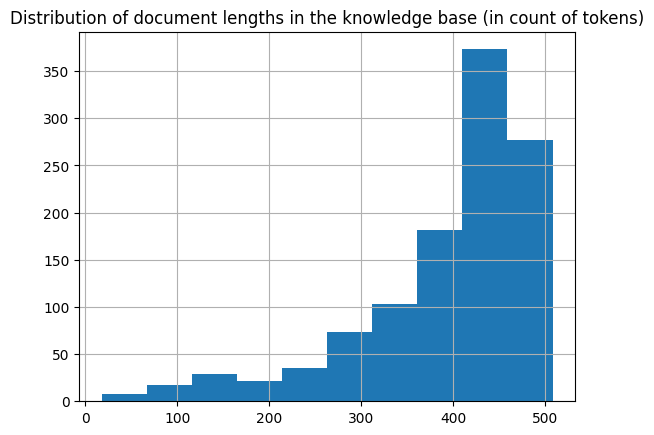

In [8]:
# Use a hierarchical list of separators specifically tailored for splitting Markdown documents
# This list is taken from LangChain's MarkdownTextSplitter class
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

EMBEDDING_MODEL_NAME = "thenlper/gte-small"

def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique


docs_processed = split_documents(
    512,  # We choose a chunk size adapted to our model
    docs,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

In [9]:
docs_processed[0]

Document(page_content='FEDERAL RESERVE press release\n\nFor release at 2:00 p.m. EDT                                             July 26, 2023  \n\nRecent indicators suggest that economic activity has been expanding at a moderate pace.\n\nJob gains have been robust in recent months, and the unemployment rate has remained low.\n\nInflation remains elevated.\n\nThe U.S. banking system is sound and resilient. Tighter credit conditions for households and businesses are likely to weigh on economic activity, hiring, and inflation. The extent of these effects remains uncertain. The Committee remains highly attentive to inflation risks.\n\nThe Committee seeks to achieve maximum employment and inflation at the rate of 2 percent over the longer run. In support of these goals, the Committee decided to raise the target range for the federal funds rate to 5-1/4 to 5-1/2 percent. The Committee will continue to assess additional information and its implications for monetary policy. In determining the

#### Embeddings & the Vector Store

In [10]:
embeddings = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    model_kwargs={"device": "cpu"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

dB = FAISS.from_documents(
    docs_processed, embeddings, distance_strategy=DistanceStrategy.COSINE
)

In [13]:
dB.save_local("faiss_index")

#### Load FAISS index

In [2]:
EMBEDDING_MODEL_NAME = "thenlper/gte-small"
embeddings = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    model_kwargs={"device": "cpu"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)
dB = FAISS.load_local("faiss_index", embeddings,allow_dangerous_deserialization=True)

/Users/tamoghnadas/opt/anaconda3/envs/aiml_langchain2/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
question = "What was Core PCE inflation in December 2022?"
searchDocs = dB.similarity_search(question)
print(searchDocs[0].page_content)
#print(searchDocs)

On a four-quarter change basis, total PCE price inflation was expected to be 5.5 percent in 2022, while core infla- tion was expected to be 4.7 percent, both lower than in the November projection. With the effects of supply– demand imbalances in goods markets expected to un- wind further and labor and product markets projected to become less tight, the staff continued to forecast that in- flation would decline markedly over the next two years. Core goods inflation was anticipated to slow further, housing services inflation was expected to peak in 2023 and then move down, while core non-housing services

Minutes of the Meeting of December 13-14, 2022

Page 7

inflation was forecast to move down as wage growth eased. In 2025, both total and core PCE price inflation were expected to be near 2 percent.

With inflation still elevated, the staff continued to view the risks to the inflation projection as skewed to the up- side. Moreover, the sluggish growth in real private do- mestic spending

In [4]:
print(f"\nStarting retrieval for {question=}...")
retrieved_docs = dB.similarity_search(query=question, k=5)
print(
    "\n==================================Top document=================================="
)
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)


Starting retrieval for question='What was Core PCE inflation in December 2022?'...

==================================Top document==================================
On a four-quarter change basis, total PCE price inflation was expected to be 5.5 percent in 2022, while core infla- tion was expected to be 4.7 percent, both lower than in the November projection. With the effects of supply– demand imbalances in goods markets expected to un- wind further and labor and product markets projected to become less tight, the staff continued to forecast that in- flation would decline markedly over the next two years. Core goods inflation was anticipated to slow further, housing services inflation was expected to peak in 2023 and then move down, while core non-housing services

Minutes of the Meeting of December 13-14, 2022

Page 7

inflation was forecast to move down as wage growth eased. In 2025, both total and core PCE price inflation were expected to be near 2 percent.

With inflation still el

#### LLM pipeline

In [11]:
#READER_MODEL_NAME = "HuggingFaceH4/zephyr-7b-beta"
READER_MODEL_NAME = "Intel/dynamic_tinybert"

'''
bnb_config = BitsAndBytesConfig(
    #load_in_4bit=True,
    llm_int8_enable_fp32_cpu_offload=True,
    bnb_4bit_use_double_quant=True, 
    bnb_4bit_quant_type="nf4", 
    bnb_4bit_compute_dtype=torch.bfloat16
)
'''
#model = AutoModelForCausalLM.from_pretrained(
#    READER_MODEL_NAME,quantization_config=bnb_config)
#model = AutoModel.from_pretrained(
#    READER_MODEL_NAME)

tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME,padding=True, truncation=True, max_length=512)

Some weights of BertModel were not initialized from the model checkpoint at Intel/dynamic_tinybert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
READER_LLM = pipeline(
    model=READER_MODEL_NAME,
    tokenizer=tokenizer,
    #task="text-generation",
    task="question-answering",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)

In [14]:
READER_LLM(
    question="Where is Nairobi?",
    context="The capital of Nigeria is Nairobi",
)

{'score': 0.7268335819244385, 'start': 15, 'end': 22, 'answer': 'Nigeria'}